An example notebook for the results of Murphy et al. (in prep.).

Expect about 3.5 GB of data to be produced by this example.

In [1]:
import numpy as np
import pylab as plt

import numpy.fft as fft
import scipy.linalg
from scipy.linalg import solve
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import LinearOperator

from scipy.sparse.linalg import cg, gmres, cgs, lgmres, minres, qmr, gcrotmk, bicg, spsolve, bicgstab
from scipy.sparse import csc_matrix

import time
from IPython.display import Image

from tqdm.notebook import tqdm
from tqdm import tqdm

from Define_Linear_Equation_PCA import Us, construct_A, construct_b, Uf

from gibbs_utils import signal_covariance_sampler as SCS
from gibbs_utils import foreground_covariance_sampler as FCS
from gibbs_utils import define_bins, bin_it

import fastbox
from fastbox.box import CosmoBox, default_cosmo
from fastbox.foregrounds import ForegroundModel
import time, sys

import os, psutil
import gc

In [2]:
""" 
Setup: Turn sampling on/off for each component, number of samples, and flagging. 
"""

s_samp = True # signal mode sampling
f_samp = True # foreground amplitude sampling
d_samp = True # data sampling
S_samp = True # signal covariance sampling
F_samp = True # and as you likely guessed: foreground covariance sampling

flagging = False

N_samples = 100

"""
Choose your favourite output folder and naming convention
"""

out_folder = 'outputs/'

name_suffix = '_gibbs_example_'

In [3]:
"""
Set the assumed initial values -> i.e. offset the true
foregrounds by 1% (both for foreground model and foreground covariance),
and the true signal by 10% (for the signal covariance only).

Use small (unrealistic) offsets for quick runs and checks (like this notebook!)
"""
f_offset_value = 0.01 
s_offset_value = 0.1

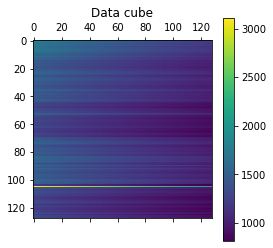

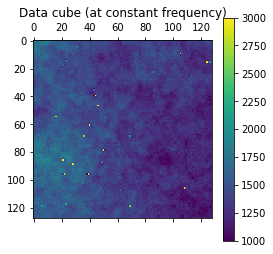

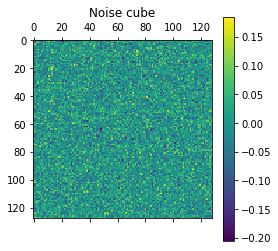

In [37]:
"""
Load some example data & generate noise.
fg_cube, signal_cube, freqs, std, and flag can all be changed
for your own data/purposes.
"""

fg_cube = np.load('data/T_FG_128.npy')
signal_cube = np.load('data/T_HI_128.npy')
freqs = np.load('data/freqs_128.npy')
shape = np.shape(signal_cube)

std = 0.05
noise_cube = np.random.normal(loc=0.0, scale=std, size=shape)

data_cube = signal_cube + noise_cube + fg_cube

if flagging:
    flag = np.load('data/flags.npy')
    data_cube = data_cube * flag


plt.matshow(data_cube[10])
plt.title('Data cube')
plt.colorbar()
plt.show()

plt.matshow(data_cube[:,:,10],vmin=1000,vmax=3000)
plt.title('Data cube (at constant frequency)')
plt.colorbar()
plt.show()

plt.matshow(noise_cube[10])
plt.title('Noise cube')
plt.colorbar()
plt.show()

In [5]:
"""
Model setup:

Only your eigenvectors should need to be changed here, the number
of eigenvector modes to be used, 
and n_k_bins, the number of power spectrum bins to be used in the 
signal covariance matrix sampling
"""

# The foreground eigenvectors
n_modes = 4
evecs = (np.load('data/fg_evecs.npy')[0:n_modes]).real

# Number of k bins for the power spectrum
n_k_bins = 14

# The true model amplitudes
f_true = Uf(evecs,fg_cube,True)
s_true = Us(signal_cube,True)

# The noise covariance and its weights
N = np.ones(shape[0]**3) * (std)**2 
N_inv = 1/N
if flagging:
    w = flag.flatten()
else:
    w = np.ones(shape[0]**3)
Nw_inv = (1/N)*w

# Track some shapes for reshaping vectors into data cubes
rfft_len = np.shape(s_true.flatten())[0]
rfft_shape = np.shape(s_true)
f_len = np.shape(f_true.flatten())[0]
f_shape = np.shape(f_true)

# Make a function for the LHS of the linear equation, Ax
def A_flat(x):
    Ax = construct_A(x, S, Nw_inv, F, w, evecs, rfft_len, rfft_shape, f_len, f_shape)
    return Ax.flatten()

# Choose the prior means for f and s
s_mean = np.zeros(np.shape(s_true))

f_offset = np.random.normal(loc=1.0,scale=f_offset_value,size=f_shape)
f_true_offset = f_true*f_offset
f_mean = f_true_offset

''' Solver starting point '''
x0 = np.concatenate([s_mean.real.flatten(),s_mean.imag.flatten(),
                     f_mean.flatten()])
x = x0

# Make an initial S estimate by randomly offsetting the true signal cube


s_init = signal_cube * np.random.normal(loc=1,scale=s_offset_value,size=shape)
s_init = np.fft.fftn(s_init,norm='ortho')
sig_k, idxs = define_bins(np.fft.fftn(s_init,norm='ortho'),n_k_bins)
binned_s, k_bins = bin_it(s_init,sig_k, idxs) 
S, _ = SCS(np.concatenate(binned_s),np.concatenate(k_bins))

# Make an initial F estimate from the initial f amplitudes

f_init = f_true_offset.reshape((shape[0]**2,n_modes))
F = FCS(f_init)
F = np.diag(F)

# Degine the linear operator

L = LinearOperator(matvec=A_flat,rmatvec=A_flat,shape=(len(x0),len(x0)))

 /users/geoffmurphy/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:Mean of empty slice.
 /users/geoffmurphy/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning:invalid value encountered in double_scalars
 /users/geoffmurphy/.local/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning:Degrees of freedom <= 0 for slice
 /users/geoffmurphy/.local/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning:invalid value encountered in true_divide
 /users/geoffmurphy/.local/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning:invalid value encountered in double_scalars


In [6]:
'''
Only 'tol' and the solver used (e.g. lgmres)
should need to be changed here
'''

for rr in tqdm(range(N_samples)):

    x0 = x 

    # Save the amplitude sample
    np.save(arr=x,file= out_folder + '/x_sample_' + str(rr) + name_suffix + '.npy')

    # Sampling terms
    if s_samp:
        ws = np.random.normal(loc=0.0,scale=1,size=rfft_shape).flatten()
    else:
        ws = 0

    if f_samp:
        wf = np.random.normal(loc=0.0,scale=1,size=n_modes)
    else:
        wf = 0

    if d_samp:
        wd = np.random.normal(loc=0.0,scale=1,size=shape).flatten()
    else:
        wd = 0
        
    b = construct_b(S, N_inv, F, w, s_mean, f_mean, evecs, data_cube, ws, wf, wd)

    # Solver and tolerance
    tol = 1e-8

    x, exit_code = lgmres(L, b.flatten(),x0=x0,tol=tol,atol=tol)
    #x, exit_code = cgs(L, b.flatten(),x0=x0,tol=tol,atol=tol)
    #x, exit_code = bicgstab(L, b.flatten(),x0=x0,tol=tol,atol=tol)
    #x, exit_code = gcrotmk(L, b.flatten(),x0=x0,tol=tol,atol=tol)

    # S sampler
    if S_samp:

        s = x[0:rfft_len].reshape(rfft_shape) + x[rfft_len:2*rfft_len].reshape(rfft_shape)*1j

        s = Us(s,False)
        s = np.fft.fftn(s,norm='ortho')
    
        binned_s, k_bins = bin_it(s, sig_k, idxs)
        S, PkSample = SCS(np.concatenate(binned_s),np.concatenate(k_bins))

        np.save(arr=PkSample,file= out_folder + '/Pk_trace' + str(rr) + name_suffix + '.npy')
        np.save(arr=S,file= out_folder + '/S_trace' + str(rr) + name_suffix + '.npy')

    else:
        pass

    # F sampler
    if F_samp:

        x_1_recon_soln = x[2*rfft_len:2*rfft_len + f_len].reshape(f_shape) #+ x[2*rfft_len + f_len:].reshape(f_shape) *1j

        f_ms = x_1_recon_soln.real

        F = FCS(f_ms.reshape((shape[0]**2,n_modes)))
        F = np.diag(F)
            
        np.save(arr=F,file= out_folder + '/F_trace' + str(rr) + name_suffix + '.npy')
    else:
        pass

    gc.collect()


print("Saved to " + out_folder)
print("Suffix: " + name_suffix)
print("")
print("n modes = " + str(n_modes))

100%|██████████| 100/100 [29:58<00:00, 17.99s/it]

Saved to outputs/
Suffix: _gibbs_example_

n modes = 4


### Results


00%|██████████| 99/99 [00:00<00:00, 102.25it/s]

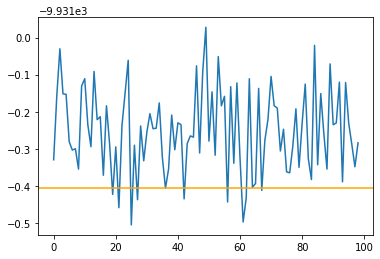

In [7]:
# Plot a trace of a single parameter, an fg mode for example.
# Determine your burn-in here.
# (Example possibly will not have converged given that this is a 
# simplistic example notebook -> draw more samples if you want!)

cut = 1 # Ignore the first sample(s) if needed
m = N_samples

pixel = [120,120]

trace = []

for jj in tqdm(range(cut,m)): 
    
    samp = np.load( out_folder + '/x_sample_' + str(jj) + name_suffix + '.npy')

    # Signal Fourier modes
    #s_soln_check = samp[0:rfft_len].reshape(rfft_shape) + samp[rfft_len:2*rfft_len].reshape(rfft_shape)*1j

    # Foreground Fourier modes
    f_soln_check = samp[2*rfft_len:2*rfft_len + f_len].reshape(f_shape)
    trace.append(f_soln_check)

plt.plot(np.array(np.array(trace)[:,pixel[0],pixel[1],0]).real)
plt.axhline(f_true[pixel[0]][pixel[1]][0].real,color='orange')
plt.show()

In [17]:
# Find the mean signal amplitudes and 
# mean foreground amplitudes

cut = 50 # Remove burn-in, wherever that may be
m = N_samples

s_solns = []
f_solns = []

for jj in tqdm(range(cut,m)): 
    samp = np.load( out_folder + '/x_sample_' + str(jj) + name_suffix + '.npy')
    s_soln_check = samp[0:rfft_len].reshape(rfft_shape) + samp[rfft_len:2*rfft_len].reshape(rfft_shape)*1j
    f_soln_check = samp[2*rfft_len:2*rfft_len + f_len].reshape(f_shape) #+ x_soln_check[2*rfft_len + f_len:].reshape(f_shape) *1j
    s_solns.append(s_soln_check)
    f_solns.append(f_soln_check)
    
s_solns_m = np.mean(s_solns, axis=0)
f_solns_m = np.mean(f_solns, axis=0)


00%|██████████| 50/50 [00:01<00:00, 49.39it/s]

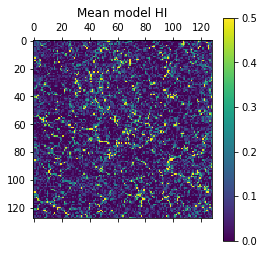

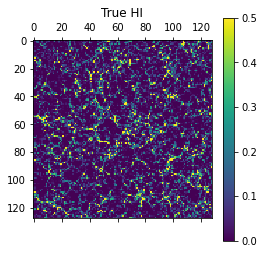

In [39]:
# Plot the means

plt.matshow(Us(s_solns_m,False)[23],vmin=0,vmax=0.5)
plt.title('Mean model HI')
plt.colorbar()
plt.show()

plt.matshow(signal_cube[23],vmin=0,vmax=0.5)
plt.title('True HI')
plt.colorbar()
plt.show()

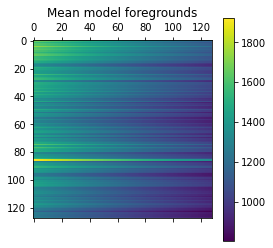

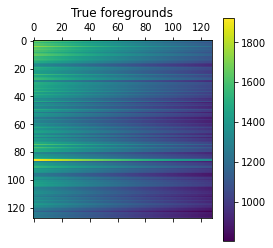

In [40]:
plt.matshow(Uf(evecs,f_solns_m,False).reshape(shape)[23])
plt.title('Mean model foregrounds')
plt.colorbar()
plt.show()

plt.matshow(fg_cube[23])
plt.title('True foregrounds')
plt.colorbar()
plt.show()

In [9]:
import fastbox
from fastbox.box import CosmoBox, default_cosmo
from fastbox.foregrounds import ForegroundModel
import time, sys

box = CosmoBox(cosmo=default_cosmo, box_scale=(1e3/0.678,1e3/0.678,1e3/0.678), nsamp=128, 
               redshift=0.39, realise_now=False)

In [10]:
# Find the power spectra of the signal samples, along with uncertainties

cut = 50 # Remove burn-in
m = N_samples

pks = np.zeros((m-cut,n_k_bins-1)) # Your power spectrum samples go in here

i = 0


for jj in tqdm(range(cut,m)): 
    
    samp = np.load( out_folder + '/x_sample_' + str(jj) + name_suffix + '.npy')

    s_soln_check = samp[0:rfft_len].reshape(rfft_shape) + samp[rfft_len:2*rfft_len].reshape(rfft_shape)*1j
    
    s_m = Us(s_soln_check, False)
    
    sig_k_s_m, sig_pk_s_m, sig_stddev_s_m, idxs = box.binned_power_spectrum(
        delta_x=s_m, nbins=n_k_bins)

    pks[i] = sig_pk_s_m
    i = i + 1



 /users/geoffmurphy/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:Mean of empty slice.
 /users/geoffmurphy/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning:invalid value encountered in double_scalars
 /users/geoffmurphy/.local/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning:Degrees of freedom <= 0 for slice
 /users/geoffmurphy/.local/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning:invalid value encountered in true_divide
 /users/geoffmurphy/.local/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning:invalid value encountered in double_scalars

00%|██████████| 50/50 [00:33<00:00,  1.51it/s]

In [23]:
# Find the 2-sigma distribution of the power spectrum samples

pmax = []
pmin = []
pmean = []
pmedian = []
for jj in range(0,n_k_bins-1):
    pmax.append(np.percentile(pks[:,jj],97.5))
    pmean.append(np.percentile(pks[:,jj],50))
    pmin.append(np.percentile(pks[:,jj],2.5))
    pmedian.append(np.median(pks[:,jj]))

In [24]:
# The true power spectrum

sig_k, sig_pk, sig_stddev,idxs = box.binned_power_spectrum(
    delta_x=signal_cube, nbins=n_k_bins)

 /users/geoffmurphy/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:Mean of empty slice.
 /users/geoffmurphy/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning:invalid value encountered in double_scalars
 /users/geoffmurphy/.local/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning:Degrees of freedom <= 0 for slice
 /users/geoffmurphy/.local/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning:invalid value encountered in true_divide
 /users/geoffmurphy/.local/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning:invalid value encountered in double_scalars


In [25]:
# The noise power spectrum

sig_n_k, sig_n_pk, sig_n_stddev, idxs = box.binned_power_spectrum(
    delta_x=noise_cube, nbins=n_k_bins)

Text(0, 0.5, 'P(k) [Mpc$^{3}$]')

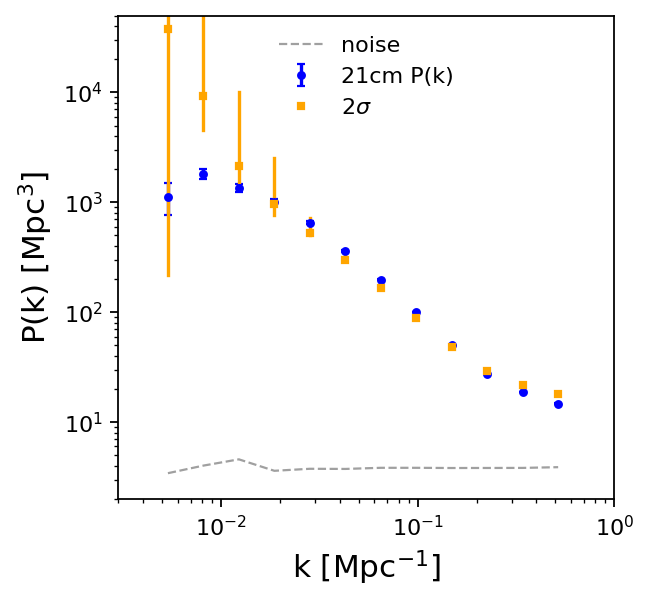

In [26]:
# Plot the recovered power spectrum (for samples which may or may
# not have converged depending on the number of samples (hint: 100 is too few))

fig, ax = plt.subplots(figsize=(4,4), dpi=160)

ax.errorbar(sig_k, sig_pk, yerr=sig_stddev, color='b', marker='.', ls='none', label="21cm P(k)", capsize=2)

for hh in range(0,n_k_bins-1):
    plt.plot([sig_k[hh],sig_k[hh]],[pmax[hh],pmin[hh]],color='orange')

ax.plot(sig_k, sig_n_pk, color='gray', alpha=0.75, linestyle='--', label="noise",linewidth=1,zorder=101)

ax.errorbar(sig_k, pmean, yerr=None, color='orange', marker='s', ls='none', label="$2\\sigma$",markersize=3)

ax.legend(loc='upper center', frameon=False)


ax.set_xlim((3e-3, 1e0))
ax.set_ylim((2e0, 5e4))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("k [Mpc$^{-1}$]", size=14)
ax.set_ylabel("P(k) [Mpc$^{3}$]", size=14)

Did anyone look at all this?